In [2]:
import pandas as pd
import sys; sys.path.append('..')
from parametric_scenario_generation.Forecast.Models import MARX
from parametric_scenario_generation.Forecast.Tools import Splines
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
heat_load = pd.read_csv('../example_data/ninja_demand_56.1496_10.2134_uncorrected.csv', index_col=0, skiprows=3)['heating_demand']
pv = pd.read_csv('../example_data/ninja_pv_56.1496_10.2134_uncorrected.csv', index_col=0, skiprows=3)['electricity']
wind = pd.read_csv('../example_data/ninja_wind_56.1496_10.2134_corrected.csv', index_col=0, skiprows=3)['electricity']
temperature = pd.read_csv('../example_data/ninja_weather_56.1496_10.2134_uncorrected.csv', index_col=0, skiprows=3)['t2m']

idx = pd.to_datetime(heat_load.index)
heat_load.index = pv.index = wind.index = temperature.index = idx

n = len(idx)
bs_df = 4
exog = Splines(seasonality=24, degrees_freedom=bs_df).get_fit(idx=idx)

In [4]:
y = pd.DataFrame({
    'Heat load': heat_load, 
    'PV': pv, 
    'Wind': wind})

n = len(y)
n_test = 168
n_train = 168 * 8
t_start = n - 168 - 168 * 0
t_test = heat_load.index[t_start:t_start + n_test]
t_train = heat_load.index[t_start - n_train:t_start]
exog_train = exog.loc[t_train,:]
exog_test = exog.loc[t_test,:]

y_train = y.loc[t_train,:]
y_test = y.loc[t_test,:]

marx = MARX()
marx.fit(y_train=y_train, exog_train=exog_train, lags=[1])

In [5]:
n_scen = 5
scenarios = marx.simulate_scenarios(y0=y_train.iloc[-1:,:], exog=exog_test, n_scen=n_scen, t_range=t_test, threads=-1)


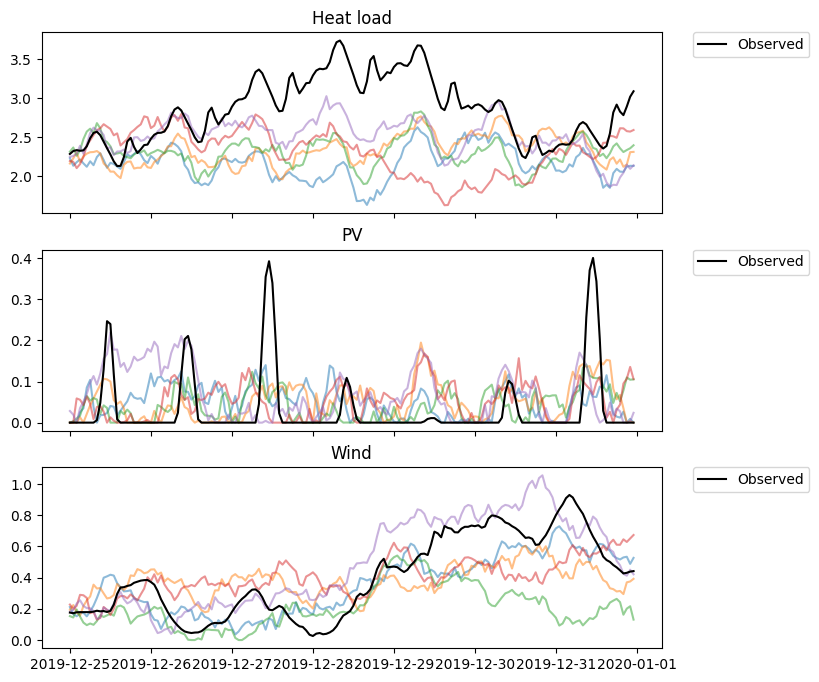

In [6]:
fig, axs = plt.subplots(nrows=len(y.columns), figsize=(8, 8), sharex=True)
for i, series in enumerate(y.columns):
    axs[i].plot(y_test[series].index, scenarios.data[series], alpha=0.5)
    axs[i].set_title(series)
    axs[i].plot(y_test[series], color='black', label='Observed')
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)